# Project 2: Ames Housing Kaggle Challenge



## Problem Statement
You've been recently hired at [Furman Realty](https://furmanrealty.com/central-iowa-mls-listings/) and your first work assignment is to build a model that will make the best possible prediction of home values in Ames, Iowa (Furman's product team would like to eventually turn this into a feature on their website, that homeowners can use to get an estimate of their house). You will be making a presentation to your inhouse product team about the process that led you to your final model and predictions.

## Executive Summary

Potential homebuyers, developers and potential investors would want to have more information on what are key features that actually contribute towards maximising the return on their investment or ensuring they don't shortchange themselves when making a sale. This is not an appraisal/definitive sale price but rather a starting point for negotations.

The more obvious inferences like having a better overall quality or a bigger size having a direct impact to the sale price. However, some interesting features were discovered to add more value to the overall value. For example, having the presence of a paved driveway, using poured concrete for your foundation or having a hipped roof, which is a type of roof where all sides slope downwards to the walls.

Features like having an unfinished garage interior, having a knob & tube wiring fusebox or having a carport(basically an unenclosed garage with 2 open sides) will hurt the sale value of a home.

If customers were interested in flipping houses (buying reasonably priced homes and refurnishing them), the neighbourhoods of Northridge Heights and Stone Brook would be of interest to potential 'investors'.

## Recommendations
There are several features that can be added to the dataset to improve the model's performance. For example:
* Home characteristics from current homeowners (including square footage, location or the number of bathrooms)
* Unique features like hardwood floors, granite countertops or a landscaped backyard (also from homeowners)
* On-market data such as listing price, description, comparable homes in the area and days on the market 
* Off-market data — tax assessments, prior sales and other publicly available records

In terms of the technical improvements, we could utilise Recursive Feature Elimation or run Feature Selector under Random Forest, to better evaluate the most effective features to utilise.

### Import relevant libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
sns.set(style="darkgrid")
%matplotlib inline 


from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


Bad key "text.kerning_factor" on line 4 in
/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
ames_train = pd.read_csv('../datasets/train.csv')
kaggle_test = pd.read_csv('../datasets/test.csv')

# EDA

In [3]:
# check the no. of rows and cols for both datasets
ames_train.shape, kaggle_test.shape

((2051, 81), (879, 80))

In [4]:
# Testing to see if the cols in both datasets are matched with no additional/missing cols
train_col_list = [x for x in ames_train.columns]
train_col_list.remove('SalePrice')
train_col_list == kaggle_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

#### all columns match up!

### Getting to the bottom of missing data

In [5]:
def retrieve_null_col(df):
    x = df.isnull().any()
    null_col_list = []
    for i,name in enumerate(x):
        if name == True:
            null_col_list.append(x.index[i])
    return null_col_list

train_null_col = retrieve_null_col(ames_train)
test_null_col = retrieve_null_col(kaggle_test)
print(len(train_null_col), "null columns in train dataset to be imputed:\n", train_null_col)
print("--------------" *5 , "\n\n")
print(len(test_null_col),"null columns in test dataset to be imputed:\n", test_null_col)
not_in_common = [i for i in train_null_col + test_null_col if i not in train_null_col or i not in test_null_col]
print("--------------" *5 )


26 null columns in train dataset to be imputed:
 ['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature']
---------------------------------------------------------------------- 


19 null columns in test dataset to be imputed:
 ['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Electrical', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature']
----------------------------------------------------------------------


#### We can observe that there are 26 null columns in the training dataset and 19 columns in the test dataset . Not all the columns are the same so this needs to be factored in when imputing missing values across both datasets.

In [6]:
# Checking the proportion of missing values in ames_train
null_section = ames_train.isnull().sum().sort_values(ascending=False).head(26)
percentage = null_section.map(lambda x: round((x/2051)*100,2))
pd.concat([null_section,percentage],axis=1,keys=['nullcount_train','train_percentage'])

,nullcount_train,train_percentage
Pool QC,2042,99.56
Misc Feature,1986,96.83
Alley,1911,93.17
Fence,1651,80.50
Fireplace Qu,1000,48.76
Lot Frontage,330,16.09
Garage Finish,114,5.56
Garage Cond,114,5.56
Garage Qual,114,5.56
Garage Yr Blt,114,5.56


In [7]:
# Checking the proportion of missing values in kaggle_test
null_section = kaggle_test.isnull().sum().sort_values(ascending=False).head(19)
percentage = null_section.map(lambda x: round((x/2051)*100,2))
pd.concat([null_section,percentage],axis=1,keys=['nullcount_test','test_percentage'])

,nullcount_test,test_percentage
Pool QC,875,42.66
Misc Feature,838,40.86
Alley,821,40.03
Fence,707,34.47
Fireplace Qu,422,20.58
Lot Frontage,160,7.80
Garage Cond,45,2.19
Garage Qual,45,2.19
Garage Yr Blt,45,2.19
Garage Finish,45,2.19


##### Recommendations:

The 6 cols Pool QC, Misc feature, Alley, Fence, Fireplace Qu, Lot Frontage have more than 10% missing data and will be removed from both datasets.

The subsequent cols pertaining to the Garage, Mas Vnr and the Bsmt have less than 10% missing data. The missing data from these cols don't seem to be random and are possibly attributed to homes without these features. We will be solve this discrepancy by imputing them with the mean.


In [8]:
#drop cols with large number of missing values
ames_train.drop(columns=['Pool QC', 'Fence', 'Misc Feature','Lot Frontage', 'Alley','Fireplace Qu'], axis=1, inplace=True)
kaggle_test.drop(columns=['Pool QC', 'Fence', 'Misc Feature','Lot Frontage', 'Alley','Fireplace Qu'], axis=1, inplace=True)

ames_train.shape, kaggle_test.shape

((2051, 75), (879, 74))

#### Can we just drop the rest of the missing rows?

In [9]:
test_drop = ames_train.dropna()
test_drop.shape

(1866, 75)

##### No.
This would result in a data loss of 9%, which would be rather significant and we're better off imputing a value into them.

[source](http://www.emgo.nl/kc/handling-missing-data/)

## Exploratory Visualizations

In [10]:
#sort dataframe into categorical and numerical for visualisation 
df_num = ames_train.select_dtypes(exclude='object')
df_cat = ames_train.select_dtypes(include='object')
list_numerical = list(ames_train.select_dtypes(exclude='object'))
list_categorical = list(ames_train.select_dtypes(include='object').columns)

In [11]:
#function to create future subplots
def subplotter(dataframe, list_of_columns, kind='bar',type_of='cat'):
    fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(20,30)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        if (kind == 'scatter') & (type_of == 'num'):
            dataframe.plot(y='SalePrice', x=column, kind=kind, ax=ax[i])
        elif (kind == 'box') & (type_of == 'cat'):
            sns.boxplot(x=column,y='SalePrice',data=ames_train, ax=ax[i])
        elif type_of == 'num':
            dataframe[column].plot(kind=kind, ax=ax[i])
        else:
            dataframe[column].value_counts().plot(kind=kind, ax=ax[i])
    for i, column in enumerate(list_of_columns):
        ax[i].set_title(column, fontsize=17)
    for i in [37,38,39]:
        fig.delaxes(ax.flatten()[i])
    plt.subplots_adjust(hspace=0.8,wspace=0.5)    

### Numerical data visualisations

We would be just plotting a scatter plot and a heatmap with each numerical col against the SalePrice for 2 reasons:

1) to find its correlation visually and;

2) to easily spot outliers

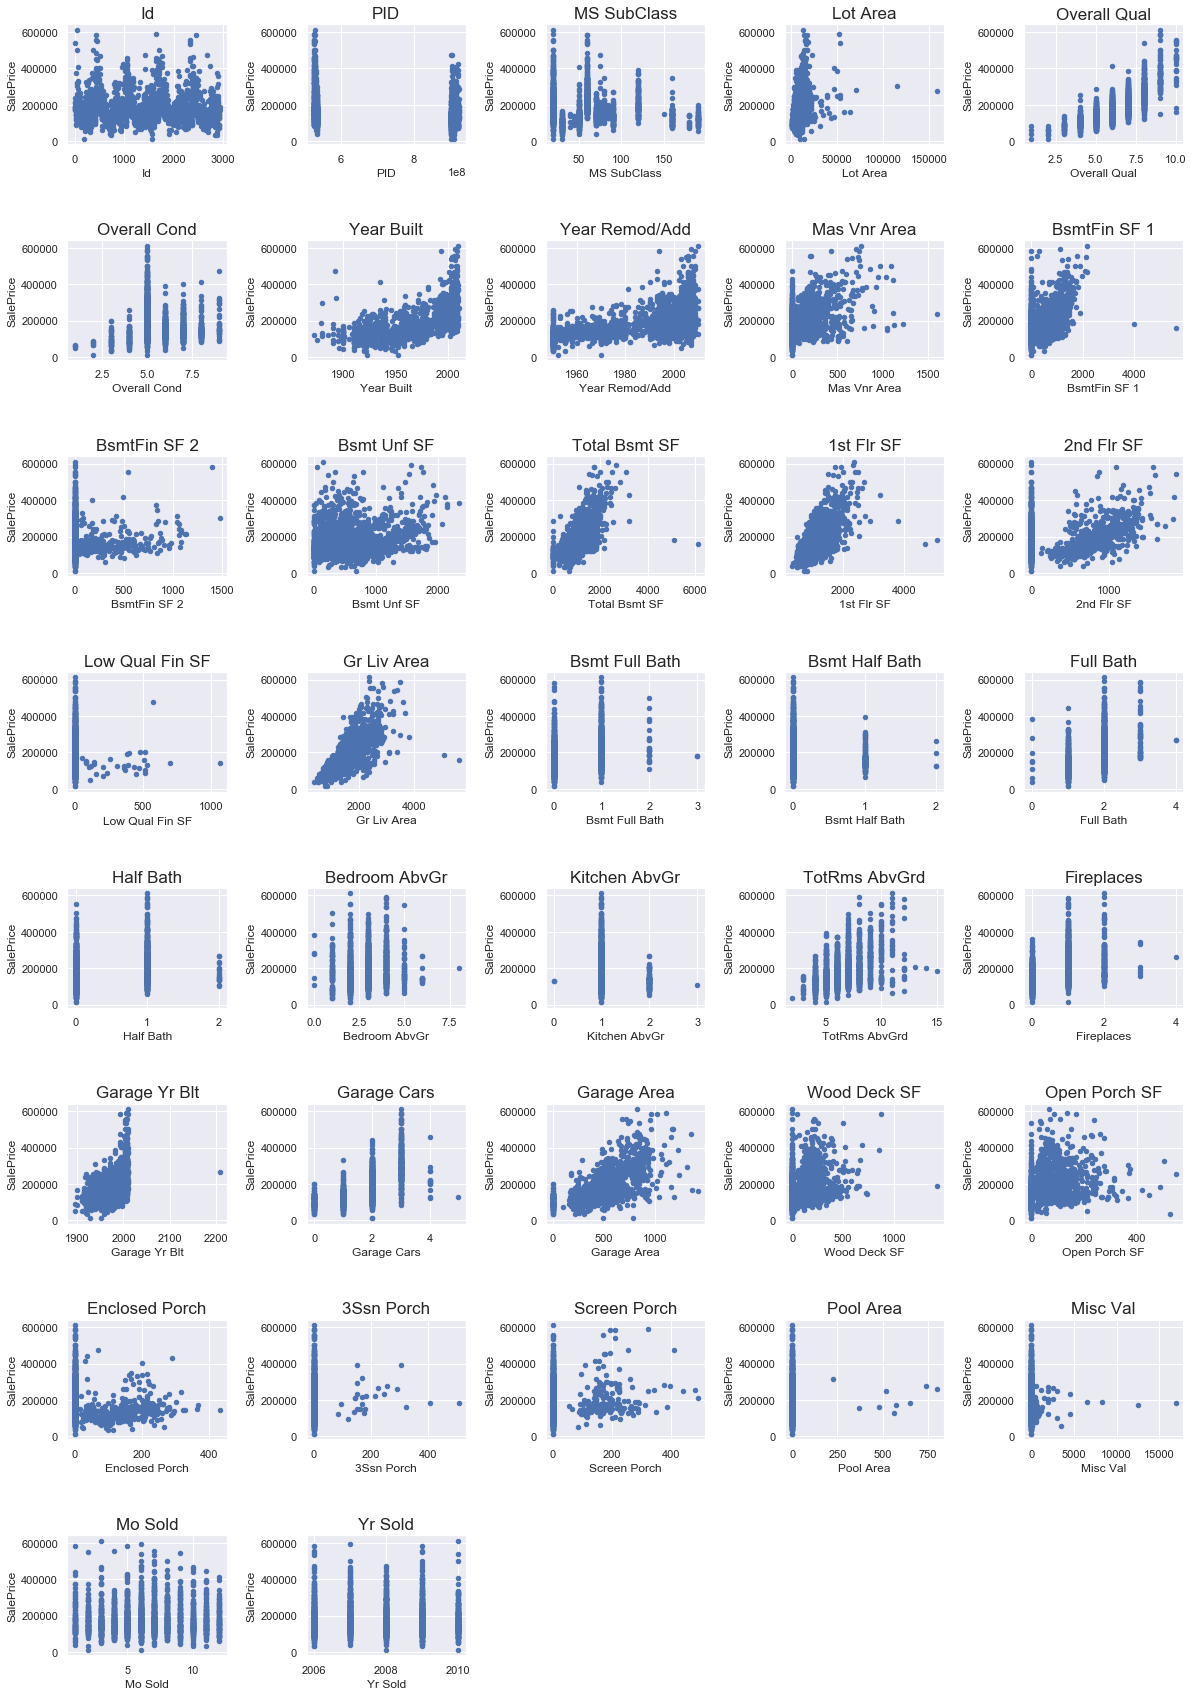

In [12]:
subplotter(df_num,list_numerical,kind='scatter', type_of='num');

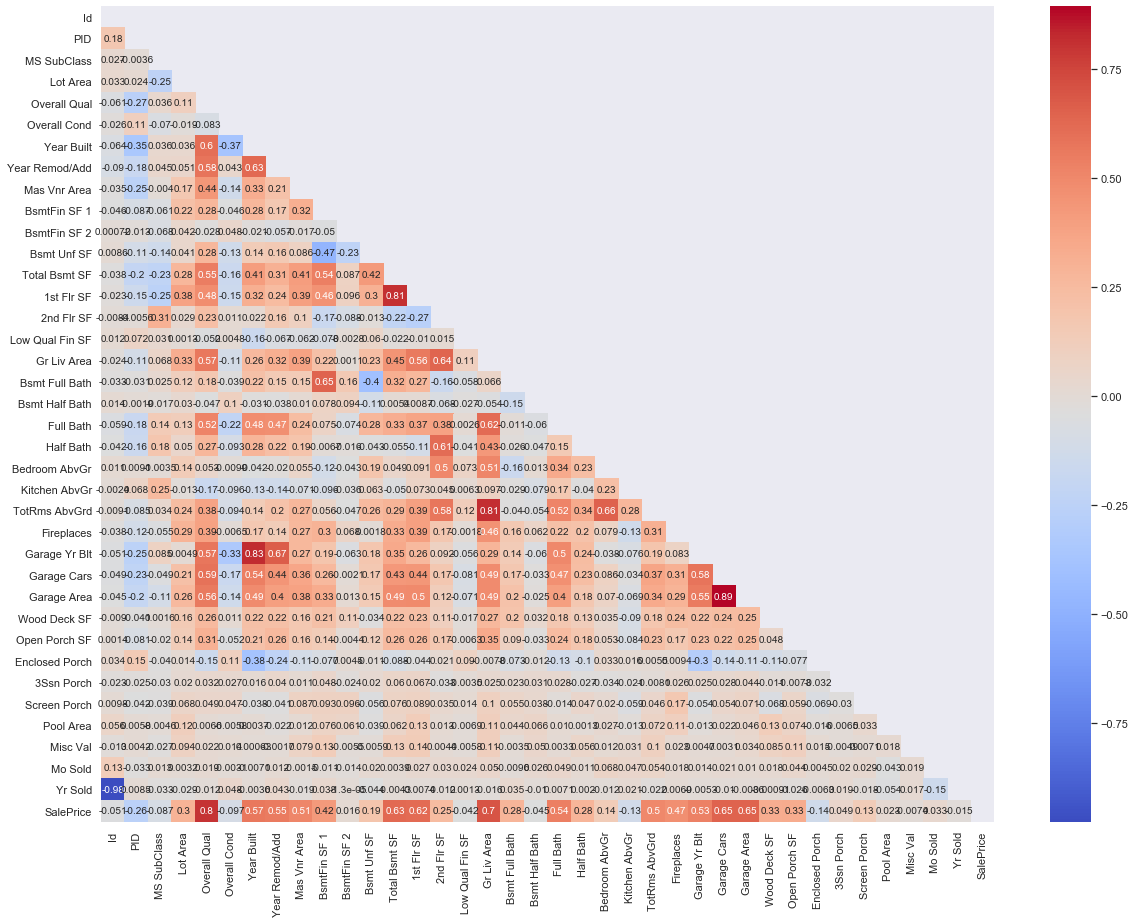

In [13]:
plt.figure(figsize=(20,15))
mask = np.triu(df_num.corr())
sns.heatmap(df_num.corr(),annot=True,mask=mask, cmap='coolwarm');

##### Observations:
* PID col to be removed since Id is main col used
* The following 11 cols will be utilised for the model: Overall Qual, Overall Cond, Yr Built, Yr remod, Total Bsmt SF, Gr Liv Area, Full Bath, Tot Rms Abv Grd, Garage yr Blt, Garage Area, External SF (combination of Wood Deck + Open Porch SF)
* These columns are supported via the heatmap correlation but multicollinearity needs to be addressed during modelling
* There are outliers to be removed (> 4k) in Tot Bsmt SF & Gr Liv Area
* As the Yr remod has imputed the yr built if there are no remods, we will relabel the col and one-hot encode it based on if it has or not undergone remod
* There is a discrepency in Garage yr blt, there is a point dated the year 2200, we'll impute the value of when the house was built to solve it


### Categorical data visualisations

We would be looking at 2 types of plots to investigate trends in the data:

1) Distribution plot of the feature

2) Boxplot with respect to SalePrice

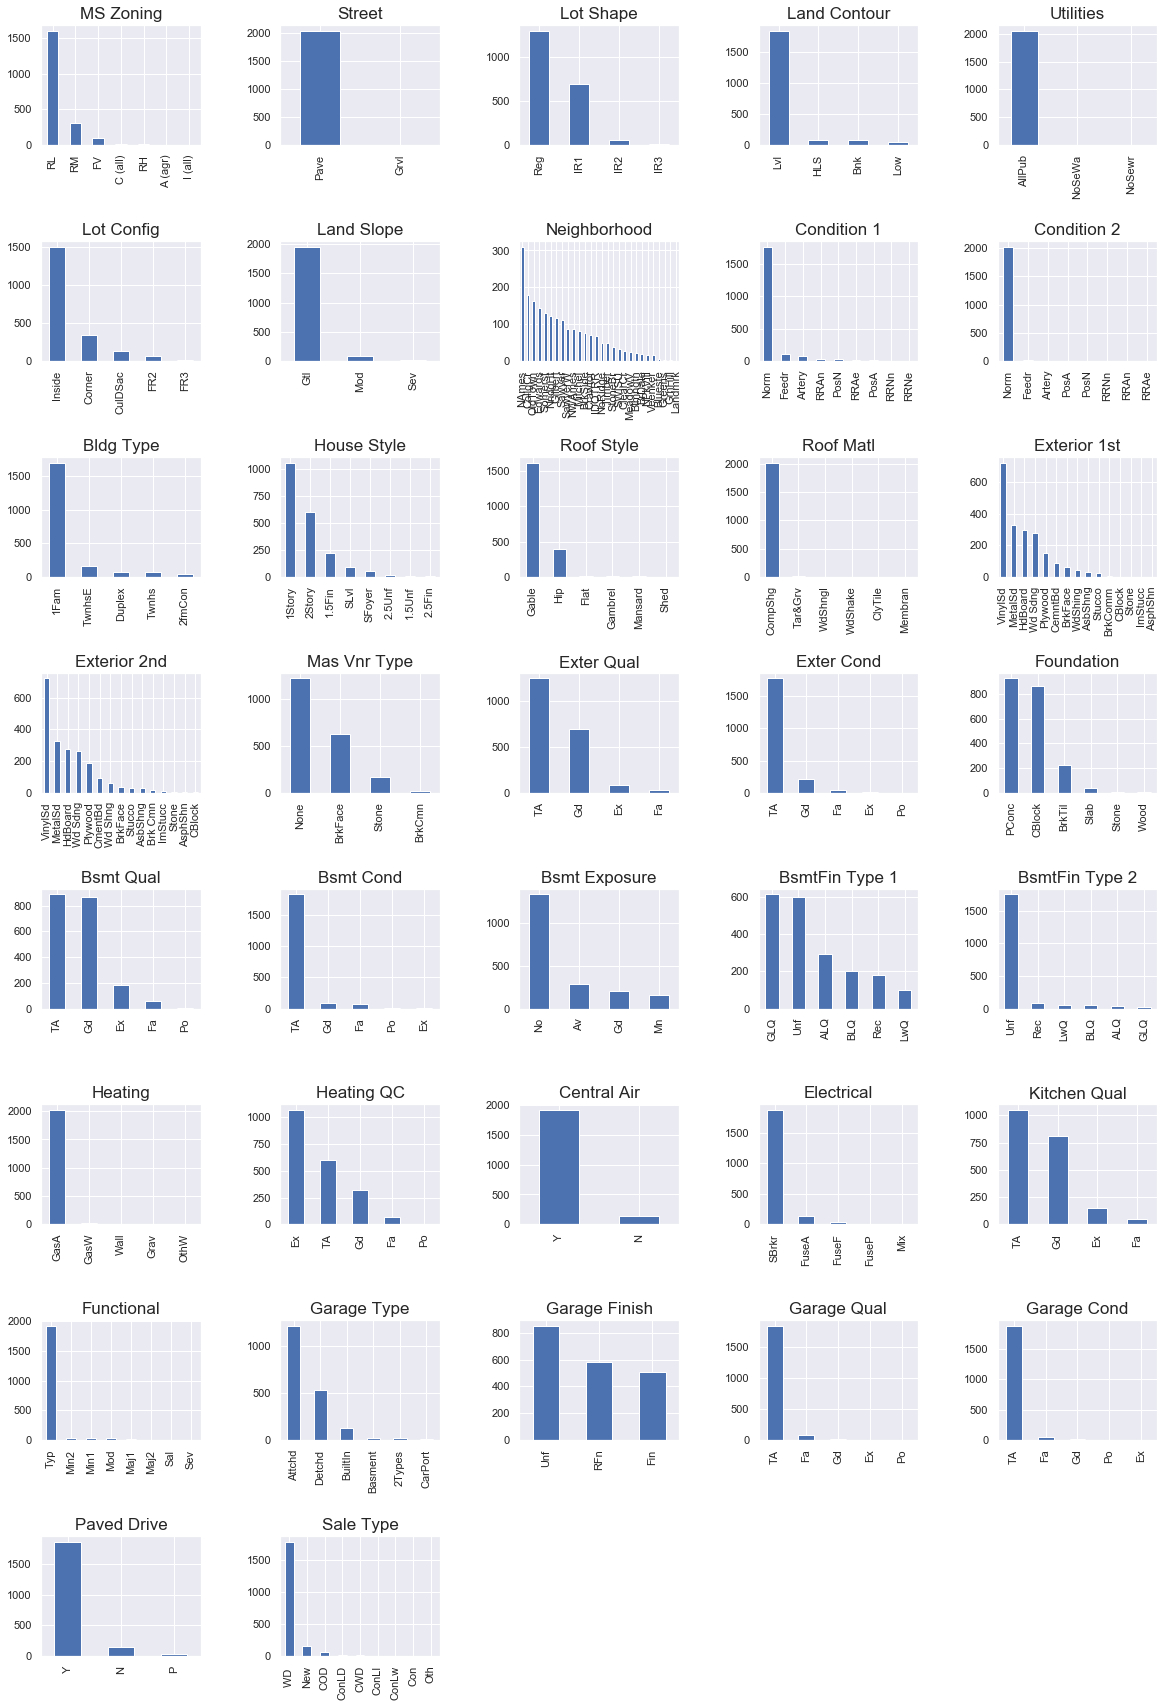

In [14]:
# Distribution plot
subplotter(df_cat,list_categorical)

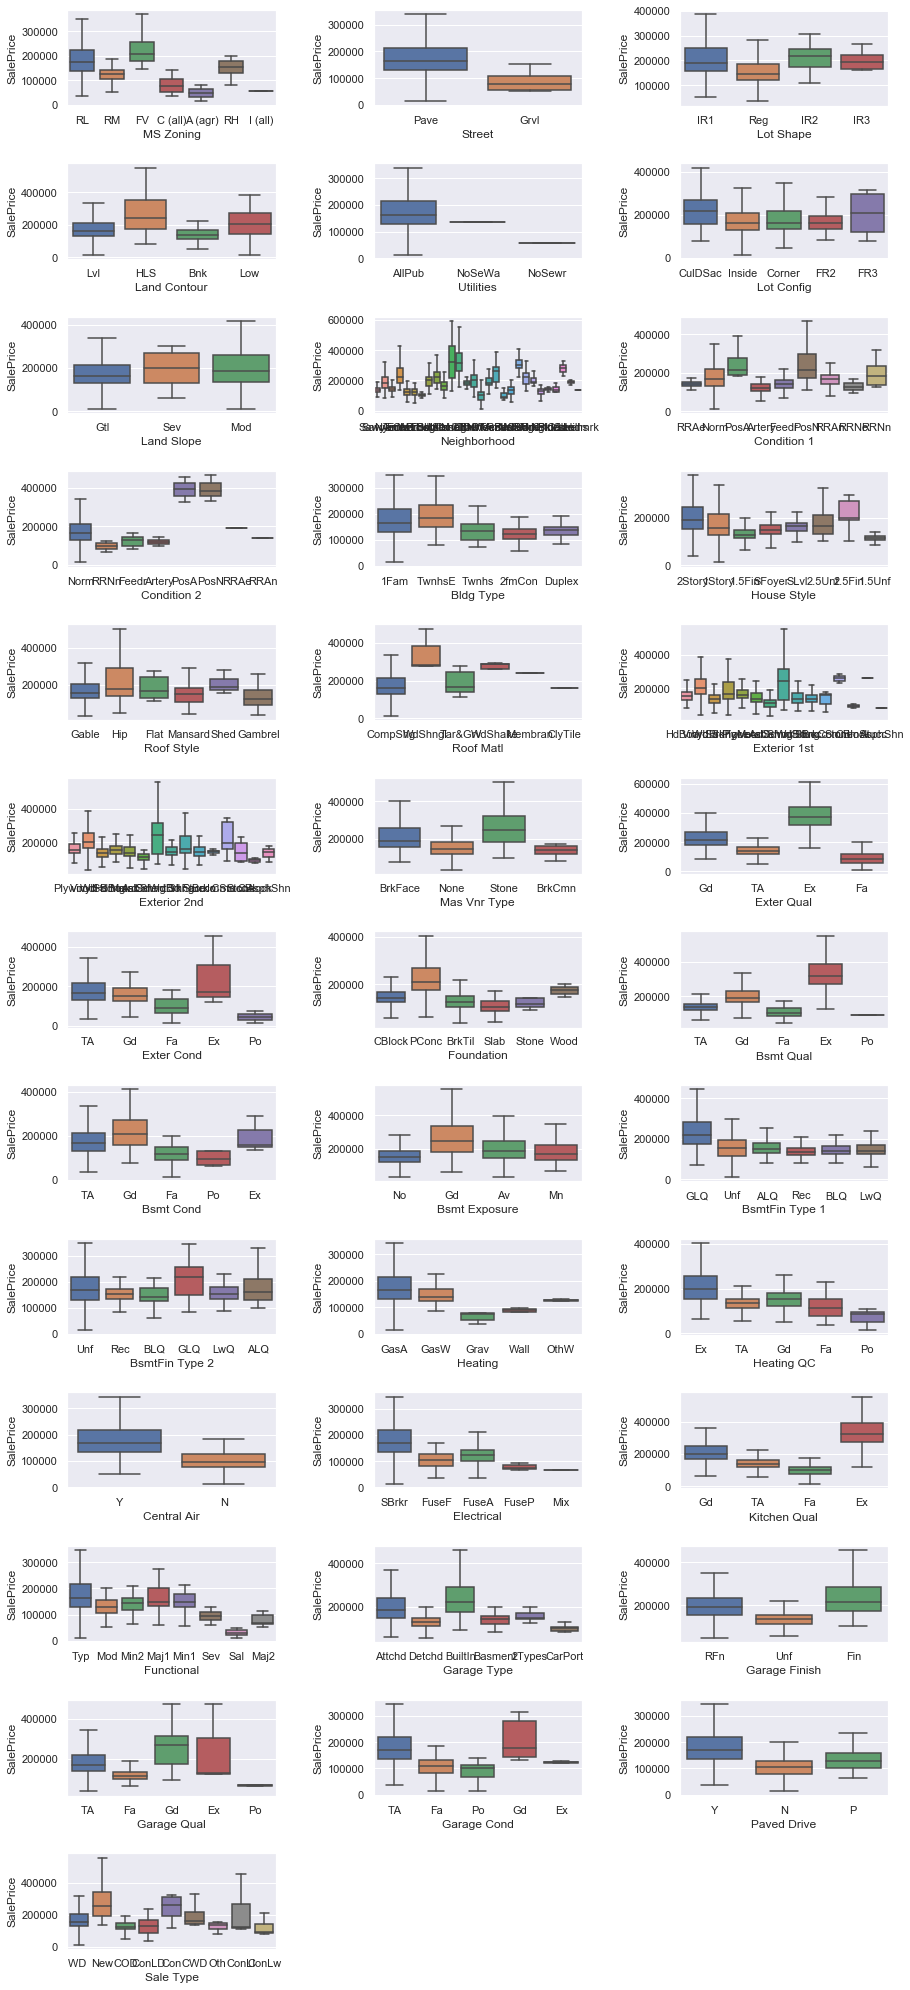

In [15]:
# boxplot of feature vs SalePrice
fig, ax = plt.subplots(nrows=13, ncols=3, figsize=(13,28)) 
ax = ax.ravel() 
for i, column in enumerate(list_categorical): 
    sns.boxplot(x=column,y='SalePrice',data=ames_train, ax=ax[i], showfliers=False)

fig.tight_layout(pad=2)
for i in [38,37]:
    fig.delaxes(ax.flatten()[i])

##### Bonus: Correlation between categorical vs continous variable
Based on pure interest, we decided to explore if we could determine a correlation between the categorical variables vs SalePrice. There was sparse literature with respect to applying this to python, apart from ANOVA test, however there was mention of using kendall and spearman methods and upon investigation. 

[In one specific piece](https://www.researchgate.net/post/Does_Spearmans_rho_have_any_advantage_over_Kendalls_tau), there was mention that the kendall method is preferred over spearman if the feature has 5 or less labels. Plotting it out in the figure below, it was intially difficult to interpret the correlation similar to the pearson method for continous variables.

We can observe that most of the ordinal features are clustered on the negative axis. How we would interpret this is that a negative score indicates a discordant relationship between the labels of the feature with respect to SalePrice. On the inverse, a positive score shows a more homogenous relationship and might add noise to the model and prevent a better prediction.

In [16]:
corr_list = []
for col in list_categorical:
    corr = df_cat[col].corr(df_num['SalePrice'], method='kendall')
    corr_list.append(corr)
corr_df = pd.DataFrame(columns=['Categorical_feature', 'Corr_value'])
corr_df['Categorical_feature'] = list_categorical
corr_df['Corr_value'] = corr_list
corr_df.head()

,Categorical_feature,Corr_value
0,MS Zoning,-0.262411
1,Street,0.065817
2,Lot Shape,-0.283341
3,Land Contour,-0.041320
4,Utilities,-0.029919


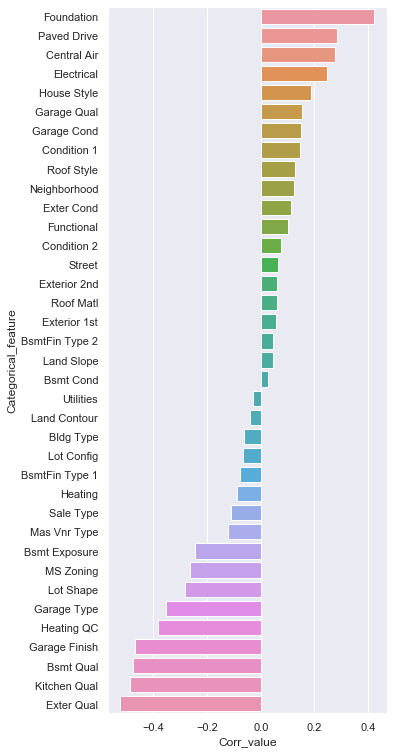

In [17]:
plt.figure(figsize=(5,13))
sns.barplot(y='Categorical_feature',x='Corr_value',data=corr_df.sort_values(['Corr_value'], ascending=False));

##### Observations:

We use the distribution and box plots to pick out 5 categorical features that have distinguishing factors which would add more value to the model :

* Neighbourhood will be one-hot encoded, and zooming into the relationship with SalePrice
* Exterior Qual, Heating QC and Garage Finish have been selected and will be label encoded as there is a clear ranking on each label (more to be explained during the data cleaning process below)
* Lot Shape, Mas Vnr Type and Electrical, upon doing external research on these features, seem to have a rank in terms of the quality of their components and it would interesting to see their impact on the model's accuracy (will be turned into ordinal)


#### Let's zoom into the neighbourhood feature and its relationship with SalePrice

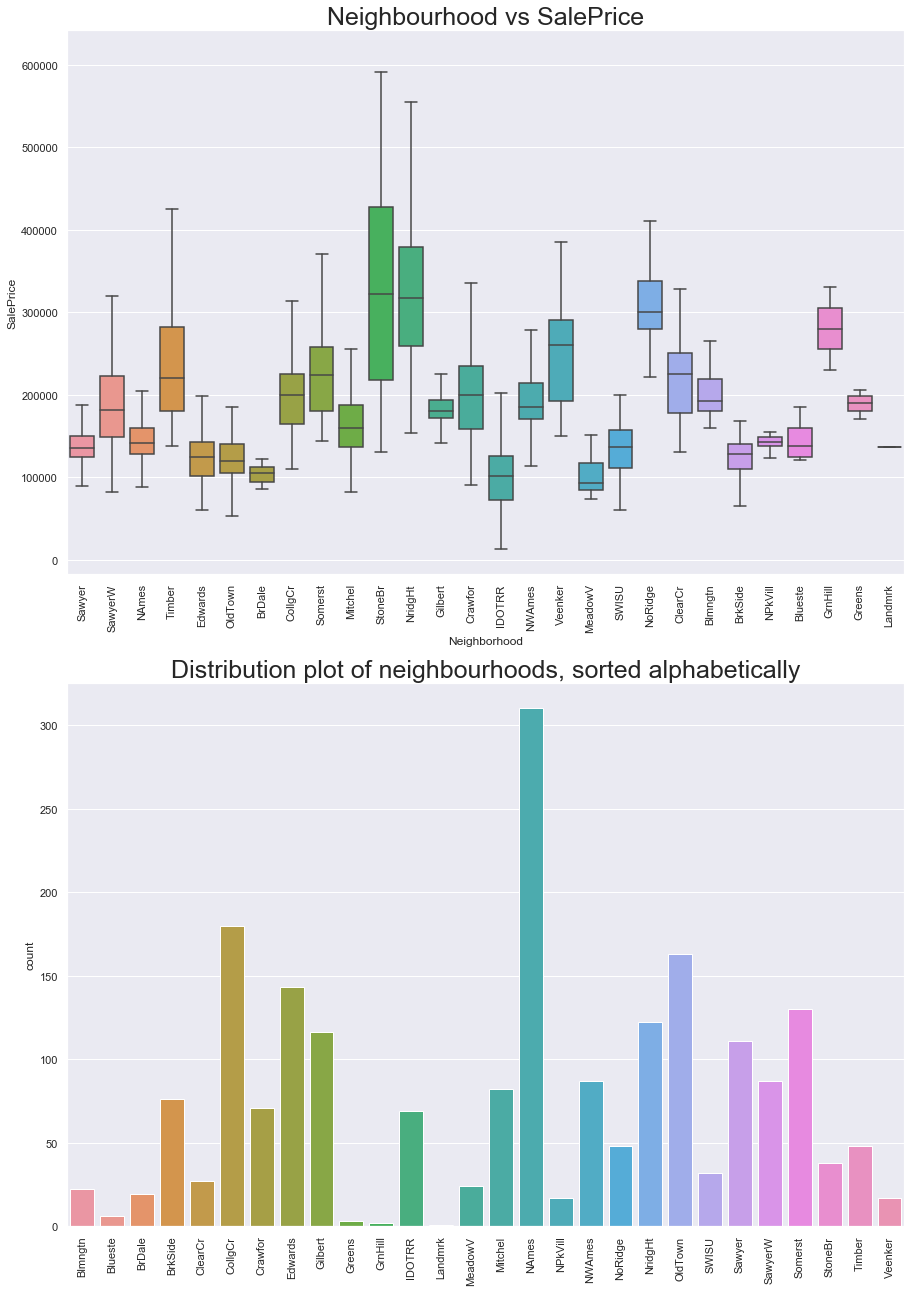

In [23]:
fig, ax = plt.subplots(2,1,figsize=(15,22))
ax[0].set_title("Neighbourhood vs SalePrice", fontsize=25)
sns.boxplot(x='Neighborhood',y='SalePrice',data=ames_train,fliersize=0,ax=ax[0])
ax[0].tick_params(axis='x',labelrotation=90)


sns.countplot(sorted(ames_train['Neighborhood']), ax=ax[1])
ax[1].tick_params(axis='x',labelrotation=90)
ax[1].set_title("Distribution plot of neighbourhoods, sorted alphabetically", fontsize=25);

##### We can observe that customers interested in 'House-flipping' would want to zoom into neighbourhoods with high variance, due to their increased potential to 'buy-low-transform-sell-high'. A point to note that most neighbourhoods don't have more than 100 observations, and we can further investigate this effect with more data observations.

### In summary: 

This is the full list of columns to be used to build our model:

1. Overall Qual
2. Overall Cond
3. Yr Built
4. Yr remod
5. Total Bsmt SF
6. Gr Liv Area
7. Full Bath
8. Tot Rms Abv Grd
9. Garage yr Blt
10. Garage Area
11. External SF (combination of Wood Deck + Open Porch SF)
12. Neighbourhood 
13. Exterior Qual
14. Garage Finish
15. Lot Shape
16. Electrical
17. Mas Vnr Type
18. Heating QC

**Let's head straight to clean up the ames_train dataset of any outliers, missing values before we proceed with the model.**

## Data Cleaning


In [19]:
# Check garage yr blt outlier
ames_train.loc[ames_train['Garage Yr Blt'] > 2020,['Year Built','Garage Type', 'Garage Area', 'Garage Yr Blt', 'Garage Cond']]

,Year Built,Garage Type,Garage Area,Garage Yr Blt,Garage Cond
1699,2006,Attchd,502.0,2207.0,TA


In [20]:
gar_yr_blt_mean = round(ames_train[ames_train['Year Built'] == 2006]['Garage Yr Blt'].mean(),0)
ames_train['Garage Yr Blt'].replace(2207.0,gar_yr_blt_mean, inplace=True)
ames_train.iloc[1699,[18, 57]]

Year Built       2006
Garage Yr Blt    2008
Name: 1699, dtype: object

**Changed the discrepancy in garage yr built by imputing the mean of the all values for houses built in the same year**
 
but before we continue, let's copy all the feature cols we require into a seperate dataframe and continue the rest of the steps.

In [21]:
cols_to_keep = ['SalePrice','Overall Qual', 'Overall Cond','Year Built','Year Remod/Add','Total Bsmt SF','Gr Liv Area','Full Bath',
                'TotRms AbvGrd','Garage Yr Blt','Garage Area','Wood Deck SF','Open Porch SF','Neighborhood',
                'Exter Qual','Garage Finish','Lot Shape','Electrical','Mas Vnr Type','Heating QC']
new_train = ames_train[[col for col in ames_train.columns if col in cols_to_keep]]
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Shape       2051 non-null   object 
 1   Neighborhood    2051 non-null   object 
 2   Overall Qual    2051 non-null   int64  
 3   Overall Cond    2051 non-null   int64  
 4   Year Built      2051 non-null   int64  
 5   Year Remod/Add  2051 non-null   int64  
 6   Mas Vnr Type    2029 non-null   object 
 7   Exter Qual      2051 non-null   object 
 8   Total Bsmt SF   2050 non-null   float64
 9   Heating QC      2051 non-null   object 
 10  Electrical      2051 non-null   object 
 11  Gr Liv Area     2051 non-null   int64  
 12  Full Bath       2051 non-null   int64  
 13  TotRms AbvGrd   2051 non-null   int64  
 14  Garage Yr Blt   1937 non-null   float64
 15  Garage Finish   1937 non-null   object 
 16  Garage Area     2050 non-null   float64
 17  Wood Deck SF    2051 non-null   i

In [22]:
# remove outliers(abv $4k) for Gr Liv Area and Tot Bsmt SF
new_train[new_train['Total Bsmt SF'] > 4000]

,Lot Shape,Neighborhood,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Type,Exter Qual,Total Bsmt SF,Heating QC,Electrical,Gr Liv Area,Full Bath,TotRms AbvGrd,Garage Yr Blt,Garage Finish,Garage Area,Wood Deck SF,Open Porch SF,SalePrice
960,IR3,Edwards,10,5,2008,2008,Stone,Ex,6110.0,Ex,SBrkr,5642,2,12,2008.0,Fin,1418.0,214,292,160000
1885,IR1,Edwards,10,5,2008,2009,Stone,Ex,5095.0,Ex,SBrkr,5095,2,15,2008.0,Fin,1154.0,546,484,183850


In [23]:
# both feature outliers are on the same row so we shall remove them both
new_train = new_train[new_train['Gr Liv Area'] < 4000]
new_train.shape

(2049, 20)

In [24]:
# find diff between remod and yr built and label 1 and 0 and rename column
new_train['Has_remod'] = new_train['Year Remod/Add'] - new_train['Year Built']
new_train.has_remod = new_train['Has_remod'].apply(lambda val: 1 if val != 0 else val)
new_train.has_remod.value_counts()

/Users/prakky/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


0    1100
1     949
Name: Has_remod, dtype: int64

In [25]:
#combine wood deck and open porch SF to become external_SF
new_train['External_SF'] = new_train['Wood Deck SF'] + new_train['Open Porch SF']

In [26]:
# drop cols : 'Year Remod/Add' , 'Wood Deck SF' , 'Open Porch SF'
new_train.drop(columns=['Year Remod/Add','Wood Deck SF','Open Porch SF'], axis=1, inplace=True)
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lot Shape      2049 non-null   object 
 1   Neighborhood   2049 non-null   object 
 2   Overall Qual   2049 non-null   int64  
 3   Overall Cond   2049 non-null   int64  
 4   Year Built     2049 non-null   int64  
 5   Mas Vnr Type   2027 non-null   object 
 6   Exter Qual     2049 non-null   object 
 7   Total Bsmt SF  2048 non-null   float64
 8   Heating QC     2049 non-null   object 
 9   Electrical     2049 non-null   object 
 10  Gr Liv Area    2049 non-null   int64  
 11  Full Bath      2049 non-null   int64  
 12  TotRms AbvGrd  2049 non-null   int64  
 13  Garage Yr Blt  1935 non-null   float64
 14  Garage Finish  1935 non-null   object 
 15  Garage Area    2048 non-null   float64
 16  SalePrice      2049 non-null   int64  
 17  Has_remod      2049 non-null   int64  
 18  External

In [27]:
#Label Encode the 6 categorical cols
# Coupled with external research and using some basic common sense, these features can be 
# turned ordinal based on their intrinsic characteristics

new_train['new_Lot Shape'] = new_train['Lot Shape'].map({'Reg':1,'IR3':2,'IR1':3,'IR2':4})
new_train['new_Garage Finish'] = new_train['Garage Finish'].map({'Unf':1,'RFn':2,'Fin':3, 0:0})
new_train['new_Exter Qual'] = new_train['Exter Qual'].map({'TA':2,'Gd':3,'Ex':4, 'Fa':1})
new_train['new_Electrical'] = new_train['Electrical'].map({'SBrkr':5,'FuseA':4,'FuseF':3, 'FuseP':2, 'Mix':1})
new_train['new_Heating QC'] = new_train['Heating QC'].map({'TA':3,'Gd':4,'Ex':5,'FA':2,'Po':1})
new_train['new_Mas Vnr Type'] = new_train['Mas Vnr Type'].map({'Stone':4,'BrkFace':3,'BrkCmn':2, 'None':0})

In [28]:
# check and impute all other nulls with 0
new_train.isnull().sum()

Lot Shape              0
Neighborhood           0
Overall Qual           0
Overall Cond           0
Year Built             0
Mas Vnr Type          22
Exter Qual             0
Total Bsmt SF          1
Heating QC             0
Electrical             0
Gr Liv Area            0
Full Bath              0
TotRms AbvGrd          0
Garage Yr Blt        114
Garage Finish        114
Garage Area            1
SalePrice              0
Has_remod              0
External_SF            0
new_Lot Shape          0
new_Garage Finish    114
new_Exter Qual         0
new_Electrical         0
new_Heating QC        67
new_Mas Vnr Type      22
dtype: int64

In [29]:
# based on the null sum, we can safely impute all values with 0, as according to the data dictionary, 
# these null values mean that there is no presence of the feature
new_train.fillna(0, inplace=True)
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Lot Shape          2049 non-null   object 
 1   Neighborhood       2049 non-null   object 
 2   Overall Qual       2049 non-null   int64  
 3   Overall Cond       2049 non-null   int64  
 4   Year Built         2049 non-null   int64  
 5   Mas Vnr Type       2049 non-null   object 
 6   Exter Qual         2049 non-null   object 
 7   Total Bsmt SF      2049 non-null   float64
 8   Heating QC         2049 non-null   object 
 9   Electrical         2049 non-null   object 
 10  Gr Liv Area        2049 non-null   int64  
 11  Full Bath          2049 non-null   int64  
 12  TotRms AbvGrd      2049 non-null   int64  
 13  Garage Yr Blt      2049 non-null   float64
 14  Garage Finish      2049 non-null   object 
 15  Garage Area        2049 non-null   float64
 16  SalePrice          2049 

**AWESOME we now have a complete dataset**

In [30]:
# dropped the original cols and renamed the new feature cols
new_train.drop(columns=['Lot Shape','Garage Finish','Exter Qual','Electrical','Mas Vnr Type','Heating QC'], axis=1, inplace=True)
new_train.columns = [col.replace('new_','') for col in new_train.columns]
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Neighborhood   2049 non-null   object 
 1   Overall Qual   2049 non-null   int64  
 2   Overall Cond   2049 non-null   int64  
 3   Year Built     2049 non-null   int64  
 4   Total Bsmt SF  2049 non-null   float64
 5   Gr Liv Area    2049 non-null   int64  
 6   Full Bath      2049 non-null   int64  
 7   TotRms AbvGrd  2049 non-null   int64  
 8   Garage Yr Blt  2049 non-null   float64
 9   Garage Area    2049 non-null   float64
 10  SalePrice      2049 non-null   int64  
 11  Has_remod      2049 non-null   int64  
 12  External_SF    2049 non-null   int64  
 13  Lot Shape      2049 non-null   int64  
 14  Garage Finish  2049 non-null   float64
 15  Exter Qual     2049 non-null   int64  
 16  Electrical     2049 non-null   int64  
 17  Heating QC     2049 non-null   float64
 18  Mas Vnr 

In [31]:
# OneHotEncode Neighbourhood col
new_train = pd.get_dummies(new_train, drop_first=True)
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Overall Qual          2049 non-null   int64  
 1   Overall Cond          2049 non-null   int64  
 2   Year Built            2049 non-null   int64  
 3   Total Bsmt SF         2049 non-null   float64
 4   Gr Liv Area           2049 non-null   int64  
 5   Full Bath             2049 non-null   int64  
 6   TotRms AbvGrd         2049 non-null   int64  
 7   Garage Yr Blt         2049 non-null   float64
 8   Garage Area           2049 non-null   float64
 9   SalePrice             2049 non-null   int64  
 10  Has_remod             2049 non-null   int64  
 11  External_SF           2049 non-null   int64  
 12  Lot Shape             2049 non-null   int64  
 13  Garage Finish         2049 non-null   float64
 14  Exter Qual            2049 non-null   int64  
 15  Electrical           

**All done! time to save it to a seperate CSV and move on to modelling**

In [32]:
new_train.to_csv('../datasets/cleaned_train.csv', index=False)